# **Indicators4CLEWs**  
**Original code:** Camilla Lo Giudice  
**Supervision:** Francesco Gardumi and Daniel Adshead  
**Funding:** IAM COMPACT


## Description of the notebook

The Notebook can be divided into six sections:  
- 1. Initialization
- 2. Creation of the directories
- 3. Conversion of model input *Data.txt* files into .csv files using otoole
- 4. Conversion of model *results.txt* files into 5 result files:
    - converted_data.csv
    - converted_data_TS.csv : contains all the results with different timeslices
    - converted_data_MoO.csv: contains all the results with different modes of operations
    - converted_data_Emissions.csv : contains all the results with emission types
    - converted_data_MoO_Emissions.csv : contains all the results with emission types and modes of operation
- 5. Indicators
- 6. Visualization

Each part will be further explained and the user will be guided through each step of the notebook. Users are required to customize the naming convention used in their specific model in the section *Configuration*.


## Configuration - to be filled by the user


In this part the user has to select the indicators of interest for the analysis. The input and output data used by the user might affect the outcome. For instance, if a result or imput data is missing it won't be possible to display the indicator. 

1. **How to select the indicator**  
For each indicator type the boolean *True* if the indicator is of interest, *False* otherwise

2. **Input the name of the variables**  
Each model can have similar but different naming conventions for the same technologies or commodities. Input the specific naming convention used in your model. For example *LNDFOR* if that is the name used for the land covered by forest. This will have to be done in the sub-section *Naming convention*. 

*Assumptions*

1) The workflow will assumes a standard format for the crops naming convention: **LND- Crop type - managment level - Irrigated/rainfed.**  
For example, if the model has an irrigated maize crop with a high managment level, the name will be: LND-MAI-H-I --> **LNDMAIHI**  

2) The same applies for other land types: all of them start with **LND- type.** For example forest will be LND - FOR --> **LNDFOR**

3) If there are crop imports, it is assumed that the naming convention will be **IMP** + the same crop names used for the other technolgies. For example for maize, it will be **IMPMAI**

### Indicators

Select *True* or *False* for each indicator

In [ ]:
Forest_Cover = True
Harvested_Area = True
Irrigated_Area = True
Yield = True
BHI = True                                  #Biodiversity Habitat Index
NE = True                                   #Net emissions
ws_aa = True                                #Average annual water stress
Crop_IDR = True                             #Crop import dependency ratio

### Naming convention

Modify the following cell with the varibale names used in your model

In [3]:
# Forest cover indicator

Forest_Land = ["LNDFOR"]        #Technology for forest cover
Total_Land = ["MINLND"]         #Technology for the land resource

In [ ]:
#Harvested area indicator
"""
Create a list of crops consistent with the naming convention used in your model. 
This will ensure more flexibility to the workflow. 
The following list provides commonly used crop names in CLEWs models.

Maize = ["MAI"]
Rice = ["RIC"] 
Cereals = ["CER"]
Coffee = ["COF"]
Oilseeds = ["OIL"]
Pulses = ["PUL"]
Sugarcane = ["SUGC"]
Sorghum = ["SOR"]
Wheat = ["WHEAT"]
Barley = ["BAR"]
Soybeans = ["SOY"]
Other_Crops = ["OTC"]"

Example with this list: Crops = ["MAI", "RIC", "CER", "COF", "OIL", "PUL", "SUGC", "SOR", "WHEAT", "BAR", "SOY", "OTC"]
"""

Crops = ["CER", "WHE", "SOR", "COF", "BRL", "MAI", "OTC"]

Irrigated = ["I"]                   #Convention for irrigated crops rrigated crops
Rainfed = ["R"]                     #Convention for rainfed crops rrigated crops 


In [5]:
Managment_level = True     # Select True if your model uses management levels and then define your naming convention

"""
Create a list of managment levels if Managment_level = True. 
The following list provides commonly used names in CLEWs models.

High_Management = ["H"]  
Intermediate_Management = ["I"]
Low_Management = ["L"]

Example list: Management_Levels = ["H", "I", "L"]
"""
Management_Levels = ["H", "L"]

In [6]:
#Yield
Yield_Unit = "Mton/10³km²"     #This unit refer to the ratio between crop production (e.g ton) over the harvested area (e.g ha). Specify the units used in your model.

In [7]:
#Biodiversity Habitat Index (BHI)

Original_Forest_area = 452         # Input the original forest area of your country. Make sure the unit of the area is consistent with the unit used in your model (e.g. km², ha, etc.)

In [8]:
#Net emissions (NE) indicator

Emission_Type = ["CO2eq"]                   # Change according to your model. If your model has only CO2 emissions, use ["CO2"]. If it has more emission types then use the CO2 equivalent
Mode_of_Operation = ["1"]                   #Change only if there is more than 1 mode of operation and the emissions are not associated to the first one
Unit_of_measure = "Mton"                    # Unit of measure for the emissions.

In [9]:
#Average annual water stress

"""
Input the name of the commodities used for the water supply.
This entails water for public use, power sector or irrigation.
"""

Initial_water_stress = 0.3  # Add the value of the initial water stress in the modelled country for the reference year.
                            # You can refer to the water risk atlas --> Water stress (https://www.wri.org/applications/aqueduct/water-risk-atlas)
                             
#Input the name of the model commodities  
Public_water = ["PUBWAT"]                  # Commodity name for public water
PWR_water = ["PWRWAT"]                     # Commodity name for cooling thermal power plants
Irrigation_water = ["AGRWAT"]              # Commodity name for irrigation water
Surface_water = ["WTRSUR"]                 # Commodity name for surface water
Ground_water = ["WTRGWT"]                  # Commodity name for groundwater
Evapotranspiration = ["WTREVT"]            # Commodity name for evapotranspiration

## 1. Initialization


In [ ]:
#Import Python modules or libraries

# Numerical
import numpy as np
import pandas as pd
import errno

# System & Other
import os
import re
from otoole import convert
import csv

#Plots
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## 2. Creation of the directories  

In [11]:
# Convert input data into csv files
ROOT_DIR = os.path.abspath(os.curdir)

#data and results input by the user
conversion_folder = "convert_from"
input = os.path.join(ROOT_DIR, conversion_folder + "\\"+ 'data.txt')
output = os.path.join(ROOT_DIR, conversion_folder + "\\"+ 'results.txt')
# Path to the configuration file
config_file = os.path.join(ROOT_DIR, "config_com.yaml")  # Update this path as needed

#folder where to save the converted csv files
Final_Data= os.path.join(ROOT_DIR, 'Data')
if not os.path.exists(Final_Data):
    try:
        os.makedirs(Final_Data)
    except OSError as exc: 
        if exc.errno != errno.EEXIST:
            raise

Final_results= os.path.join(ROOT_DIR, 'Results')
if not os.path.exists(Final_results):
    try:
        os.makedirs(Final_results)
    except OSError as exc: 
        if exc.errno != errno.EEXIST:
            raise

converted_input = os.path.join(ROOT_DIR, Final_Data + "\\"+ 'Model input')
if not os.path.exists(converted_input):
    try:
        os.makedirs(converted_input)
    except OSError as exc: 
        if exc.errno != errno.EEXIST:
            raise
converted_output = os.path.join(ROOT_DIR, Final_Data + "\\"+ 'Model output')
if not os.path.exists(converted_output):
    try:
        os.makedirs(converted_output)
    except OSError as exc: 
        if exc.errno != errno.EEXIST:
            raise

Plots = os.path.join(ROOT_DIR, 'Plots')
if not os.path.exists(Plots):
    try:
        os.makedirs(Plots)
    except OSError as exc: 
        if exc.errno != errno.EEXIST:
            raise


## 3. Conversion of model input Data.txt files into csv
This step uses the otoole environment for converting input data into csv files.Then the following three cells convert the results.txt file into three csv files: one with technologies with modes of operation, one with values per each time slice and one with only annual values (not considering neither modes of operation nor time-slices). The converted outputs will be stored into Data/Model input and in Data/Model output folders. The first one is used for the data converted from the data.txt file, while the second one contains the data converted from the results.txt file.

In [12]:
#Fix txt file

def fix_txt_file(input):
    """
    Fixes the format of the data.txt file into a new data_fixed.txt. 
    The fixed parameters are `UDCTag`, `OperationalLifeStorage`, `StorageLevelStart`, and `UDCConstant`.
    
    """
    output_file = input.replace('.txt', '_fixed.txt')

    params_single_line_fix = [
        "UDCTag",
        "OperationalLifeStorage",
        "StorageLevelStart"
    ]

    params_udc_constant = ["UDCConstant"]

    with open(input, 'r') as f:
        lines = f.readlines()

    fixed_lines = []
    i = 0

    while i < len(lines):
        line = lines[i].strip()
        fixed = False

        for param in params_single_line_fix:
            if line.startswith(f"param {param} default"):
                if i + 3 < len(lines):
                    line2 = lines[i + 1].strip()
                    line4 = lines[i + 3].strip()
                    if line2 == ":=" and line4 == ";":
                        cleaned_line = re.sub(r'\s*:\s*$', '', line)
                        cleaned_line = re.sub(r'\s*:=\s*$', '', cleaned_line)
                        fixed_lines.append(f"{cleaned_line} :=\n")
                        fixed_lines.append(";\n")
                        i += 4
                        fixed = True
                        break

        for param in params_udc_constant:
            if line.startswith(f"param {param} default"):
                if i + 5 < len(lines):
                    line5 = lines[i + 5].strip()
                    if line5 == ";":
                        cleaned_line = re.sub(r'\s*:\s*$', '', line)
                        cleaned_line = re.sub(r'\s*:=\s*$', '', cleaned_line)
                        fixed_lines.append(f"{cleaned_line} :=\n")
                        fixed_lines.append(";\n")
                        i += 6
                        fixed = True
                        break

        if not fixed:
            fixed_lines.append(lines[i])
            i += 1

    with open(output_file, 'w') as f:
        f.writelines(fixed_lines)

    print(f"Fixed input file created: {output_file}")
    return output_file

fixed_input_file = fix_txt_file(input)
input_fixed = os.path.join(ROOT_DIR, conversion_folder + "\\"+ 'data_fixed.txt')
print(f"Fixed file created at: {fixed_input_file}")




Fixed input file created: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\convert_from\data_fixed.txt
Fixed file created at: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\convert_from\data_fixed.txt


In [13]:
# Convert the input data to CSV files

def convert_input_to_csv(config_path, input_path, output_folder):
    """
    Converts a data.txt file into CSV files and stores them in the specified folder.

    Arguments
    ---------
    config_path : str
        Path to the configuration file.
    input_path : str
        Path to the input data_fixed.txt file.
    output_folder : str
        Path to the folder where the converted CSV files will be stored.

    Returns
    -------
    bool
        True if conversion was successful, False otherwise.
    """
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise

    # Perform the conversion
    try:
        success = convert(
            config=config_path,
            from_format="datafile",
            to_format="csv",
            from_path=input_path,
            to_path=output_folder,
            write_defaults=False,
            keep_whitespace=False,
        )
        return success
    except Exception as e:
        print(f"An error occurred during conversion: {e}")
        return False
    
# Convert the input data to CSV files
conversion_success = convert_input_to_csv(config_file, input_fixed, converted_input)

if conversion_success:
    print(f"Data conversion succeeded. CSV files are stored in: {converted_input}")
else:
    print("Conversion failed.")

Data conversion succeeded. CSV files are stored in: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Data\Model input


## 4. Conversion of model results.txt file into csv


In [14]:
#Convert the results to CSV files

def convert_results_to_csv(input_path, output_folder):
    """
    Converts the MUIO results.txt file into CSV files and stores them in the specified folder.

    Arguments
    ---------
    input_path : str
        Path to the input txt file.
    output_folder : str
        Path to the folder where the converted CSV files will be stored.

    Returns
    -------
    bool
        True if conversion was successful, False otherwise.
    """
  
    try:
        # Open the input txt file
        with open(input_path, 'r') as txt_file:
            lines = txt_file.readlines()

        # Prepare the output CSV file
        output_csv_path = os.path.join(output_folder, "converted_data.csv")
        with open(output_csv_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # Write the header row
            csv_writer.writerow(["PARAMETER", "REGION", "TECHNOLOGY", "YEAR", "VALUE",])

            # Parse each line in the txt file
            for line in lines:
                # Split the line into columns based on fixed-width formatting
                parts = line.strip().split()
                if len(parts) < 3:
                    continue  # Skip invalid lines

                # Extract the parameter, and values
                parameter_info = parts[1]
                value = parts[2]

                # Parse the parameter info (e.g., NewCapacity(RE1,PWRHYDLRG,2020))
                if "(" in parameter_info and ")" in parameter_info:
                    parameter, details = parameter_info.split("(")
                    details = details.strip(")").split(",")
                    if len(details) == 3:
                        region, technology, year = details
                        # Write the parsed data to the CSV file
                        csv_writer.writerow([parameter, region, technology, year, value,])

        return True
    except Exception as e:
        print(f"An error occurred during conversion: {e}")
        return False

# Call the function to convert the custom txt file to CSV
conversion_success = convert_results_to_csv(output, converted_output)

if conversion_success:
    print(f"Data conversion succeeded. CSV files are stored in: {converted_output}")
else:
    print("Conversion failed.")

Data conversion succeeded. CSV files are stored in: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Data\Model output


In [15]:
#Convert the results to CSV files with TimeSlices

def convert_resultsTS_to_csv(input_path, output_folder):
    """
    Converts the MUIO results.txt file into CSV files with time-slices and stores them in the specified folder.

    Arguments
    ---------
    input_path : str
        Path to the input txt file.
    output_folder : str
        Path to the folder where the converted CSV files will be stored.

    Returns
    -------
    bool
        True if conversion was successful, False otherwise.
    """
  
    try:
        # Open the input txt file
        with open(input_path, 'r') as txt_file:
            lines = txt_file.readlines()

        # Prepare the output CSV file
        output_csv_TS_path = os.path.join(output_folder, "converted_data_TS.csv")
        with open(output_csv_TS_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # Write the header row
            csv_writer.writerow(["PARAMETER", "REGION", "TECHNOLOGY","TIMESLICE","YEAR", "VALUE",])

            # Parse each line in the txt file
            for line in lines:
                # Split the line into columns based on fixed-width formatting
                parts = line.strip().split()
                if len(parts) < 4:
                    continue  # Skip invalid lines

                # Extract the parameter, and values
                parameter_info = parts[1]
                value = parts[2]

                # Parse the parameter info 
                if "(" in parameter_info and ")" in parameter_info:
                    parameter, details = parameter_info.split("(")
                    details = details.strip(")").split(",")
                    if len(details) == 4:
                        region, technology, time_slice, year = details
                        
                        # Skip if the time-slice is a number
                        if time_slice.isdigit():
                            continue

                        # Skip if the parameter is "AnnualTechnologyEmission" or "InputToTotalCapacity"
                        if parameter in ["AnnualTechnologyEmission", "InputToTotalCapacity", "Demand"]:
                            continue

                        # Write the parsed data to the CSV file
                        csv_writer.writerow([parameter, region, technology, time_slice, year, value,])

        return True
    except Exception as e:
        print(f"An error occurred during conversion: {e}")
        return False

# Call the function to convert the custom txt file to CSV
conversion_success = convert_resultsTS_to_csv(output, converted_output)

if conversion_success:
    print(f"Data conversion succeeded. CSV files are stored in: {converted_output}")
else:
    print("Conversion failed.")

Data conversion succeeded. CSV files are stored in: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Data\Model output


In [16]:
#Convert the results to CSV files with Modes of operation

def convert_resultsMoO_to_csv(input_path, output_folder):
    """
    Converts the MUIO results.txt with modes of operation (MoO) into CSV files with time-slices and stores them in the specified folder.

    Arguments
    ---------
    input_path : str
        Path to the input txt file.
    output_folder : str
        Path to the folder where the converted CSV files will be stored.

    Returns
    -------
    bool
        True if conversion was successful, False otherwise.
    """
  
    try:
        # Open the input txt file
        with open(input_path, 'r') as txt_file:
            lines = txt_file.readlines()

        # Prepare the output CSV file
        output_csv_MoO_path = os.path.join(output_folder, "converted_data_MoO.csv")
        with open(output_csv_MoO_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # Write the header row
            csv_writer.writerow(["PARAMETER", "REGION", "TECHNOLOGY","MODE_OF_OPERATION","YEAR", "VALUE",])

            # Parse each line in the txt file
            for line in lines:
                # Split the line into columns based on fixed-width formatting
                parts = line.strip().split()
                if len(parts) < 4:
                    continue  # Skip invalid lines

                # Extract the parameter, and values
                parameter_info = parts[1]
                value = parts[2]

                # Parse the parameter info 
                if "(" in parameter_info and ")" in parameter_info:
                    parameter, details = parameter_info.split("(")
                    details = details.strip(")").split(",")
                    if len(details) == 4:
                        region, technology, mode_of_operation, year = details
                        if mode_of_operation.isdigit(): # Modes of operaion can be only > 1
                            # Write the parsed data to the CSV file
                            csv_writer.writerow([parameter, region, technology, mode_of_operation, year, value,])

        return True
    except Exception as e:
        print(f"An error occurred during conversion: {e}")
        return False

# Call the function to convert the custom txt file to CSV
conversion_success = convert_resultsMoO_to_csv(output, converted_output)

if conversion_success:
    print(f"Data conversion succeeded. CSV files are stored in: {converted_output}")
else:
    print("Conversion failed.")

Data conversion succeeded. CSV files are stored in: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Data\Model output


In [17]:
#Convert the emission results to CSV files 

def convert_resultsEMI_to_csv(input_path, output_folder):
    """
    Converts the MUIO results.txt file into CSV files with emissions and stores them in the specified folder.

    Arguments
    ---------
    input_path : str
        Path to the input txt file.
    output_folder : str
        Path to the folder where the converted CSV files will be stored.

    Returns
    -------
    bool
        True if conversion was successful, False otherwise.
    """
  
    try:
        # Open the input txt file
        with open(input_path, 'r') as txt_file:
            lines = txt_file.readlines()

        # Prepare the output CSV file
        output_csv_EMI_path = os.path.join(output_folder, "converted_data_Emissions.csv")
        with open(output_csv_EMI_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # Write the header row
            csv_writer.writerow(["PARAMETER", "REGION", "TECHNOLOGY","EMISSION","YEAR", "VALUE",])

            # Parse each line in the txt file
            for line in lines:
                # Split the line into columns based on fixed-width formatting
                parts = line.strip().split()
                if len(parts) < 4:
                    continue  # Skip invalid lines

                # Extract the parameter, and values
                parameter_info = parts[1]
                value = parts[2]

                # Parse the parameter info 
                if "(" in parameter_info and ")" in parameter_info:
                    parameter, details = parameter_info.split("(")
                    details = details.strip(")").split(",")
                    if len(details) == 4:
                        region, technology, emission, year = details
                        
                        # Skip if the time-slice is a number
                        if emission.isdigit():
                            continue

                        # Skip if the parameter is "AnnualTechnologyEmission" or "InputToTotalCapacity"
                        if parameter in [ "RateOfTotalActivity","InputToTotalCapacity", "Demand"]:
                            continue

                        # Write the parsed data to the CSV file
                        csv_writer.writerow([parameter, region, technology, emission, year, value,])

        return True
    except Exception as e:
        print(f"An error occurred during conversion: {e}")
        return False

# Call the function to convert the custom txt file to CSV
conversion_success = convert_resultsEMI_to_csv(output, converted_output)

if conversion_success:
    print(f"Data conversion succeeded. CSV files are stored in: {converted_output}")
else:
    print("Conversion failed.")

Data conversion succeeded. CSV files are stored in: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Data\Model output


In [18]:
#Convert the emission results to CSV files with Modes of Operation (MoO)

def convert_resultsEMIMoO_to_csv(input_path, output_folder):
    """
    Converts the MUIO results.txt file into CSV files with emissions with MoO and stores them in the specified folder.

    Arguments
    ---------
    input_path : str
        Path to the input txt file.
    output_folder : str
        Path to the folder where the converted CSV files will be stored.

    Returns
    -------
    bool
        True if conversion was successful, False otherwise.
    """
    try:
        # Open the input txt file
        with open(input_path, 'r') as txt_file:
            lines = txt_file.readlines()

        # Prepare the output CSV file
        output_csv_EMIMoO_path = os.path.join(output_folder, "converted_data_MoO_Emissions.csv")
        with open(output_csv_EMIMoO_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # Write the header row
            csv_writer.writerow(["PARAMETER", "REGION", "TECHNOLOGY", "EMISSION", "MODE_OF_OPERATION", "YEAR", "VALUE"])

            # Parse each line in the txt file
            for line in lines:
                # Split the line into columns based on fixed-width formatting
                parts = line.strip().split()
                if len(parts) < 3:  # Ensure the line has enough parts
                    #print(f"Skipping line (not enough parts): {line.strip()}")
                    continue

                # Extract the parameter and value
                parameter_info = parts[1]
                value = parts[2]

                # Parse the parameter info
                if "(" in parameter_info and ")" in parameter_info:
                    parameter, details = parameter_info.split("(")
                    details = details.strip(")").split(",")
                    if len(details) == 5:  # Ensure the details have the expected structure
                        region, technology, emission, mode, year = details

                        if parameter in [ "RateOfActivity"]:
                            continue

                        # Write the parsed data to the CSV file
                        csv_writer.writerow([parameter, region, technology, emission, mode, year, value])
                    

        return True
    except Exception as e:
        print(f"An error occurred during conversion: {e}")
        return False

# Call the function to convert the custom txt file to CSV
conversion_success = convert_resultsEMIMoO_to_csv(output, converted_output)

if conversion_success:
    print(f"Data conversion succeeded. CSV files are stored in: {converted_output}")
else:
    print("Conversion failed.")

Data conversion succeeded. CSV files are stored in: c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Data\Model output


## 5. Indicators


### 5.1 Forest cover  
The forest cover shows the share of land covered by forest mesured in %. <br><br>
$$Forest\_Cover = \frac{Total\_land\_covered\_by\_forest}{Total\_land}$$


In [ ]:
#Run the cell for the Forest Cover indicator
if Forest_Cover == False:
    exit()

input_csv = os.path.join(converted_output, 'converted_data.csv')
output_csv = os.path.join(Final_results, 'Forest_cover.csv')

# Read the input CSV file
try:
    data = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: The file {input_csv} does not exist.")
    exit()

# Filter the data 
filtered_data = data[data["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Initialize a dictionary to store the results
results = {"INDICATOR": [], "VALUE": [], "UNIT": [], "YEAR": []}
           

# Loop through each year and calculate the ratio
for year in filtered_data["YEAR"].unique():
    # Filter data for the current year
    year_data = filtered_data[filtered_data["YEAR"] == year]
    
    # Get the value for forest land
    lndfor_value = year_data[year_data["TECHNOLOGY"].isin(Forest_Land)]["VALUE"].sum()
    
    # Get the value for total land
    rsclnd_value = year_data[year_data["TECHNOLOGY"].isin(Total_Land)]["VALUE"].sum()
    
    # Calculate the ratio if RSCLND value is not zero
    if rsclnd_value != 0:
        ratio = round((lndfor_value / rsclnd_value) * 100, 3)
        results["INDICATOR"].append("ForestCover")
        results["VALUE"].append(ratio)
        results["UNIT"].append("%")
        results["YEAR"].append(year)
        

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv(output_csv, index=False)

print(f"Forest cover indicators have been successfully saved to {output_csv}.")


Forest cover indicators have been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Forest_cover.csv.


### 5.2 Harvested area  
This indicator shows the share of total harvested land (both rainfed or irrigated), calculated as <br><br>
$$Harvested\_Area = \frac{Total\_land\_harvested}{Total\_land}$$  
Note that the type of crops might vary greatly depending on the case study country. If a specific crop is missing from the ones proposed, add it in the configuration cell. Additionally, models can vary in complexity. A part from distinguishing between rainfed and irrigated, it is possible to model also three generic input/management levels defined in the GAEZ v4.0 model documentation:  
- *Low level input:*  
   Traditional managment assumption  
- *Intermediate level inputs:*  
   Improved managment assumption
- *High level input:*  
   Advanced managment assumption

For this indicator the configuration cell will be split in three main cells: managment level, crop types and irrigated/rainfed. This is due to the high flexiility that each user has in shaping the land use. The workflow will assume the standard format used for naming crops: **LND- Crop type - managment level - Irrigated/rainfed.**  

For example, if the model has an irrigated maize crop with a high managment level, the name will be: LND-MAI-H-I --> **LNDMAIHI**  


For the GAEZ v4 model documentation refer to https://openknowledge.fao.org/server/api/core/bitstreams/6b7b9b4a-dbac-4af4-a2cb-26aff33a30e5/content 

##### Harvested area indicator


In [ ]:
# Run the cell for the harvested Area indicator
if Harvested_Area == False:
    exit()

# Paths
input_csv = os.path.join(converted_output, 'converted_data.csv')
output_csv = os.path.join(Final_results, 'Harvested_area.csv')

# Read the input CSV file
try:
    data = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: The file {input_csv} does not exist.")
    exit()

# Filter the data for the parameter "TotalTechnologyAnnualActivity"
filtered_data = data[data["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Initialize a dictionary to store the results
results = {"INDICATOR": [], "VALUE": [], "UNIT": [], "YEAR": []}

# Build the regular expression for filtering technologies
crop_regex = "|".join(Crops)  
irrigation_regex = "|".join(Irrigated + Rainfed)  

# Check if management levels are used
if Managment_level:
    management_regex = "|".join(Management_Levels)  
    technology_regex = f"LND({crop_regex})({management_regex})({irrigation_regex})"
else:
    technology_regex = f"LND({crop_regex})({irrigation_regex})"

# calculate the ratio
for year in filtered_data["YEAR"].unique():
    # Filter data for the current year
    year_data = filtered_data[filtered_data["YEAR"] == year]

    # Filter technologies that match the naming convention
    harvested_area_data = year_data[year_data["TECHNOLOGY"].str.contains(technology_regex, flags=re.IGNORECASE, na=False)]

    # Calculate the sum of harvested area
    harvested_area_sum = harvested_area_data["VALUE"].sum()

    # Get the total land value for the year
    total_land_data = year_data[year_data["TECHNOLOGY"].isin(Total_Land)]
    total_land_value = total_land_data["VALUE"].sum()

    # Calculate the ratio if total land value is not zero
    if total_land_value != 0:
        ratio = round((harvested_area_sum / total_land_value) * 100, 3)  
        results["INDICATOR"].append("HarvestedArea")
        results["VALUE"].append(ratio)
        results["UNIT"].append("%")
        results["YEAR"].append(year)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv(output_csv, index=False)
print(f"Harvested area indicators have been successfully saved to {output_csv}.")

Harvested area indicators have been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Harvested_area.csv.


C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\2024955578.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  harvested_area_data = year_data[year_data["TECHNOLOGY"].str.contains(technology_regex, flags=re.IGNORECASE, na=False)]


### 5.3 Area under irrigation  
This indicator shows the share of total irrigated land, calculated as: <br><br>
$$Irrigated\_Area = \frac{Total\_land\_Irrigated}{Total\_land\_harvested}$$  

Note that the configuration cells are the same as for the indicator above. Make sure to run that ones before running the indicator code cell. 


##### Irrigated area indicator

In [ ]:
# Run the cell for the Irrigated Area indicator
if Irrigated_Area == False:
    exit()

# Paths
input_csv = os.path.join(converted_output, 'converted_data.csv')
output_csv = os.path.join(Final_results, 'Irrigated_area.csv')

# Read the input CSV file
try:
    data = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: The file {input_csv} does not exist.")
    exit()

# Filter the data for the parameter "TotalTechnologyAnnualActivity"
filtered_data = data[data["PARAMETER"] == "TotalTechnologyAnnualActivity"]


results = {"INDICATOR": [], "VALUE": [], "UNIT": [], "YEAR": []}

crop_regex = "|".join(Crops)  
irrigation_regex = "|".join(Irrigated)  
rainfed_regex = "|".join(Rainfed) 

# Check if management levels are used
if Managment_level:
    management_regex = "|".join(Management_Levels)  # Combine management levels dynamically
    irrigated_technology_regex = f"LND({crop_regex})({management_regex})({irrigation_regex})"
    total_harvested_technology_regex = f"LND({crop_regex})({management_regex})({irrigation_regex}|{rainfed_regex})"
else:
    irrigated_technology_regex = f"LND({crop_regex})({irrigation_regex})"
    total_harvested_technology_regex = f"LND({crop_regex})({irrigation_regex}|{rainfed_regex})"

# Loop through each year and calculate the ratio
for year in filtered_data["YEAR"].unique():
    # Filter data for the current year
    year_data = filtered_data[filtered_data["YEAR"] == year]

    # Filter technologies for irrigated area (numerator)
    irrigated_area_data = year_data[year_data["TECHNOLOGY"].str.contains(irrigated_technology_regex, flags=re.IGNORECASE, na=False)]
    irrigated_area_sum = irrigated_area_data["VALUE"].sum()

    # Filter technologies for total harvested area (denominator)
    total_harvested_area_data = year_data[year_data["TECHNOLOGY"].str.contains(total_harvested_technology_regex, flags=re.IGNORECASE, na=False)]
    total_harvested_area_sum = total_harvested_area_data["VALUE"].sum()

    # Calculate the ratio if total harvested area is not zero
    if total_harvested_area_sum != 0:
        ratio = round((irrigated_area_sum / total_harvested_area_sum) * 100, 3)  
        results["INDICATOR"].append("Irrigated Area")
        results["VALUE"].append(ratio)
        results["UNIT"].append("%")
        results["YEAR"].append(year)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv(output_csv, index=False)

print(f"Irrigated area indicators have been successfully saved to {output_csv}.")

Irrigated area indicators have been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Irrigated_area.csv.


C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3711753768.py:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  irrigated_area_data = year_data[year_data["TECHNOLOGY"].str.contains(irrigated_technology_regex, flags=re.IGNORECASE, na=False)]
C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3711753768.py:46: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  total_harvested_area_data = year_data[year_data["TECHNOLOGY"].str.contains(total_harvested_technology_regex, flags=re.IGNORECASE, na=False)]


### 5.4 Crop yield

This indicator represents the overall yield of a given crop. Note that this yield is different from the  one the user has to input into the model. The output activity ratio is indeed crop specific and varies according to the type of farming considered (e.g rainfed/irrigated or high/low mechanization). This indicator estimates the overall yield, defined as the ratio between the total crop production over the total harvested land for that crop:  <br><br><br>


 $$Crop\_yield = \frac{Total\_Production}{Total\_harvested\_Area} $$  

 Make sure to run the configuration cells in 5.2 for defining the crops. This indicator assumes also that the name of the crop commodity is the same as one used in the technologies (e.g if for Maize was "MAI", then the same will be for the commodity). The *format* of the commodity name is consistent to the one adopted in most of CLEWs models: CRP + name --> e.g CRP-MAI --> **CRPMAI**  
 

##### Yield indicator

In [ ]:
# Run the cell for the Crop yield indicator
if Yield == False:
    exit()

# Paths
output_activity_ratio_csv = os.path.join(converted_input, 'OutputActivityRatio.csv')
total_technology_activity_csv = os.path.join(converted_output, 'converted_data.csv')
output_csv = os.path.join(Final_results, 'Crop_Yield.csv')

try:
    output_activity_ratio_data = pd.read_csv(output_activity_ratio_csv)
    total_technology_activity_data = pd.read_csv(total_technology_activity_csv)

    # Filter for the correct parameter
    total_technology_activity_data = total_technology_activity_data[
        total_technology_activity_data["PARAMETER"] == "TotalTechnologyAnnualActivity"
    ]
except FileNotFoundError as e:
    print(f"Error: {e}")
    # raise or return instead of exit() in notebooks
    raise

results = {"CROP": [], "VALUE": [], "UNIT": [], "YEAR": []}

# filter technologies
crop_regex = "|".join(Crops)  
irrigation_regex = "|".join(Irrigated + Rainfed)  

# Include management levels in the regex if enable
if Managment_level:                           
    management_regex = "|".join(Management_Levels)
    technology_regex = f"LND({crop_regex})({management_regex})({irrigation_regex})"
else:
    technology_regex = f"LND({crop_regex})({irrigation_regex})"                      


for crop in Crops:
    crop_technology_regex = f"LND{crop}"  # Matches technologies like LNDMAI, LNDRIC
    commodity_name = f"CRP{crop}"  # Matches commodities like CRPMAI, CRPRIC

    # Filter OutputActivityRatio data for the current crop
    crop_output_data = output_activity_ratio_data[
        (output_activity_ratio_data["TECHNOLOGY"].str.contains(technology_regex, na=False)) &
        (output_activity_ratio_data["COMMODITY"] == commodity_name)
    ]

    # Filter TotalTechnologyAnnualActivity data for the current crop
    crop_activity_data = total_technology_activity_data[
        total_technology_activity_data["TECHNOLOGY"].str.contains(technology_regex, na=False)
    ]

    # Loop through each year to calculate the yield
    for year in crop_activity_data["YEAR"].unique():
        # Filter data for the current year
        year_output_data = crop_output_data[crop_output_data["YEAR"] == year]
        year_activity_data = crop_activity_data[crop_activity_data["YEAR"] == year]

        # Calculate the numerator: sum(OutputActivityRatio * TotalTechnologyAnnualActivity)
        numerator = 0
        for _, row in year_output_data.iterrows():
            technology = row["TECHNOLOGY"]
            output_ratio = row["VALUE"]
            # Find the corresponding activity value for the same technology
            activity_value = year_activity_data[year_activity_data["TECHNOLOGY"] == technology]["VALUE"].sum()
            numerator += output_ratio * activity_value

        # Calculate the denominator: sum(TotalTechnologyAnnualActivity)
        denominator = year_activity_data["VALUE"].sum()

        # Calculate the yield 
        if denominator != 0:
            yield_value = round(numerator / denominator, 3) 
            results["CROP"].append(crop)
            results["VALUE"].append(yield_value)
            results["UNIT"].append(Yield_Unit) 
            results["YEAR"].append(year)
                    

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv(output_csv, index=False)

print(f"Yield indicators have been successfully saved to {output_csv}.")

C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3294888946.py:48: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (output_activity_ratio_data["TECHNOLOGY"].str.contains(technology_regex, na=False)) &
C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3294888946.py:54: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  total_technology_activity_data["TECHNOLOGY"].str.contains(technology_regex, na=False)


Yield indicators have been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Crop_Yield.csv.


### 5.5 Biodiversity

The Biodiversity Habitat Index (BHI) assesses the effects of habitat loss, degradation, and fragmentation on the retention of terrestrial biodiversity in a region. The indicator exploits the species-area relationship: <br><br><br>


 $$BHI = \frac{Forest\_Area\_Retained}{Original\_Forest\_Area}^{0.25} $$
 

 

 In this analysis, 0.25 represents the exponent *z* of the species–area relationship, a widely accepted value for this type of assessment.
 The results show the % increase (or decrease) in biodiversity.
 Being CLEWs models not spatially explicit, we refered to the simplified relationship presented by Simon Ferrier et al. (2004). For more information refer to: BioScience, Volume 54, Issue 12, December 2004, Pages 1101–1109, https://doi.org/10.1641/0006-3568(2004)054[1101:MMOTBF]2.0.CO;2 



##### BHI indicator


In [ ]:
# Exit if the indicator is not of interest
if BHI == False:
    exit()

# Paths
input_csv = os.path.join(converted_output, 'converted_data.csv')
BHI_output_csv = os.path.join(Final_results, 'BHI.csv')

# Read the input CSV file
try:
    data = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: The file {input_csv} does not exist.")
    exit()

# Filter the data for the parameter "TotalTechnologyAnnualActivity"
filtered_data = data[data["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Initialize a dictionary to store the results
results = {"INDICATOR": [], "VALUE": [], "UNIT": [], "YEAR": []}

# Loop through each year and calculate the BHI
for year in filtered_data["YEAR"].unique():
    # Filter data for the current year
    year_data = filtered_data[filtered_data["YEAR"] == year]
    
    # Get the value for forest land
    lndfor_value = year_data[year_data["TECHNOLOGY"].isin(Forest_Land)]["VALUE"].sum()
    
    # Calculate the BHI
    if Original_Forest_area != 0: 
        ratio = round(((lndfor_value / Original_Forest_area) ** 0.25)*100, 3)
        results["INDICATOR"].append("BHI")
        results["VALUE"].append(round(ratio, 3))
        results["UNIT"].append("%")
        results["YEAR"].append(year)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv(BHI_output_csv, index=False)

print(f"BHI indicator has been successfully saved to {BHI_output_csv}.")

BHI indicator has been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\BHI.csv.


### 5.6 Net Emissions

The Net Emissions (NE) indicator is a quantitative estimation of the net CO2 equivalent produced. It considers direct emissions and land use change emissions which are both output of the CLEWs model. Note that in most CLEWs application the emission activity ratio for forest is negative, taking into account that it works as a carbon sink. The estimation is therefore an algebraic sum of all the technologies with an emission factor associated. The output is already a net balance for each year. 

In [ ]:
# Exit if the indicator is not of interest
if NE == False:
    exit()

# Paths
input_csv = os.path.join(converted_output, 'converted_data_MoO_Emissions.csv')
NE_output_csv = os.path.join(Final_results, 'Net_emissions.csv')

# Read the input CSV file
try:
    data = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: The file {input_csv} does not exist.")
    exit()

# Check if the input file is empty
if data.empty:
    print("The input CSV file is empty.")
    exit()


# Filter the data for the parameter "AnnualTechnologyEmissionByMode"
filtered_data_directEmissions = data[data["PARAMETER"] == "AnnualTechnologyEmissionByMode"]
filtered_data_LUC = data[data["PARAMETER"] == "EmissionByActivityChange"]

# Group the direct emissions by year
direct_emissions = filtered_data_directEmissions.groupby("YEAR")["VALUE"].sum().reset_index()
direct_emissions.rename(columns={"VALUE": "DIRECT_EMISSIONS"}, inplace=True)

# Group the LUC emissions by year
LUC_emissions = filtered_data_LUC.groupby("YEAR")["VALUE"].sum().reset_index()
LUC_emissions.rename(columns={"VALUE": "LUC_EMISSIONS"}, inplace=True)

# Merge the two datasets on YEAR
merged_emissions = pd.merge(direct_emissions, LUC_emissions, on="YEAR", how="left")

# Replace NaN values in LUC_EMISSIONS with 0
merged_emissions["LUC_EMISSIONS"].fillna(0, inplace=True)

# Calculate the total emissions
merged_emissions["TOTAL_EMISSIONS"] = merged_emissions["DIRECT_EMISSIONS"] + merged_emissions["LUC_EMISSIONS"]

# Round the values
merged_emissions["TOTAL_EMISSIONS"] = merged_emissions["TOTAL_EMISSIONS"].round(3)

# Add the indicator and unit columns
merged_emissions["INDICATOR"] = "NetEmissions"
merged_emissions["UNIT"] = Unit_of_measure

# Select the final columns
results = merged_emissions[["INDICATOR", "TOTAL_EMISSIONS", "UNIT", "YEAR"]]
results.rename(columns={"TOTAL_EMISSIONS": "VALUE"}, inplace=True)

# Save the results to a CSV file
results.to_csv(NE_output_csv, index=False)

print(f"Net emission indicator has been successfully saved to {NE_output_csv}.")


Net emission indicator has been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Net_emissions.csv.


C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\2905873364.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.rename(columns={"TOTAL_EMISSIONS": "VALUE"}, inplace=True)


### 5.7 Average annual water stress and relative water demand

The water stress can be calculated as the ratio of the total water demand over the total available renewable surface and groundwater supplies (also known as relative water demand). It is suitable for models with low temporal resolution. The steps for calculating the indicator are the following: <br><br>
*Step 1: calculate the relative water demand* <br><br><br>

$$ r = \frac{Total\_Annual\_Gross\_Demand}{Total\_Annual\_Available\_Water}$$  

The annual demand includes public and industrial uses and the demand associated to the power and agricultural sectors.

*Step 2: calculate the water average annual stress*<br><br><br>

$$ws_{aa} = \min(1, \max(0, r))$$  


*Step 3: conversion to risk categories*<br><br><br>

$$Average\_Annual\_score = \max\left(0, \min\left(5, \frac{ln(ws_{aa})-ln(0.1)}{ln(2)} +1\right)\right)$$  

The risk cathegory follows the same values and methodlogy used by WRI and then adapted to a CLEWs model. The code returns two csv files: one for the relative water demand and one with the average water stress per each modelled year.


For more information about the methodology adopted by WRI refer to https://files.wri.org/d8/s3fs-public/2023-08/aqueduct-40-technical-note.pdf?VersionId=G_TxTR2LAnlgXGzy7xtdUP_5lmkXJY7d


In [ ]:
# Exit if the indicator is not of interest
if ws_aa == False:
    exit()

# Paths
IAR_csv = os.path.join(converted_input, "InputActivityRatio.csv")
OAR_csv = os.path.join(converted_input, "OutputActivityRatio.csv")
Water_annual_demand_sp_csv = os.path.join(converted_input, "SpecifiedAnnualDemand.csv")
Water_annual_demand_annual_csv = os.path.join(converted_input, "AccumulatedAnnualDemand.csv")
output_Activity_csv = os.path.join(converted_output, "converted_data.csv")
r_csv = os.path.join(Final_results, "Relative_annual_water_demand.csv")
Annual_average_ws_score = os.path.join(Final_results, "Annual_average_ws_score.csv")

# Read the input CSV files
try:
    data_IAR = pd.read_csv(IAR_csv)
except FileNotFoundError:
    print(f"Error: The file {IAR_csv} does not exist.")
    exit()
if data_IAR.empty:
    print("The {IAR_csv} file is empty.")
    exit()

try:
    data_OAR = pd.read_csv(OAR_csv)
except FileNotFoundError:
    print(f"Error: The file {OAR_csv} does not exist.")
    exit()
if data_OAR.empty:
    print("The {OAR_csv} file is empty.")
    exit()

try:
    data_Water_demand_sp = pd.read_csv(Water_annual_demand_sp_csv)
except FileNotFoundError:
    print(f"Error: The file {Water_annual_demand_sp_csv} does not exist.")
    exit()
if data_Water_demand_sp[ data_Water_demand_sp["COMMODITY"].isin(Public_water) ].empty:
    print(f"The commodity {Public_water} is not present in {Water_annual_demand_sp_csv}.")

try:
    data_Water_demand_annual = pd.read_csv(Water_annual_demand_annual_csv)
except FileNotFoundError:
    print(f"Error: The file {Water_annual_demand_annual_csv} does not exist.")
    exit()
if data_Water_demand_annual.empty:
    print("The {Water_annual_demand_annual_csv} file is empty.")
    exit()

try:
    data_activity = pd.read_csv(output_Activity_csv)
except FileNotFoundError:
    print(f"Error: The file {output_Activity_csv} does not exist.")
    exit()
if data_activity.empty:
    print("The {output_Activity_csv} file is empty.")
    exit()

The commodity ['PUBWAT'] is not present in c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Data\Model input\SpecifiedAnnualDemand.csv.


##### Water demand 

In [ ]:
# 1. Water demand for cooling thermal power plants
# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Filter data_IAR for the commodity PWRWAT
filtered_IAR = data_IAR[data_IAR["COMMODITY"].isin(PWR_water)]

# Filter data_Rate_activity for the parameter RateOfTotalActivity
filtered_activity = data_activity[data_activity["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Merge the two datasets on REGION, TECHNOLOGY, and YEAR
merged_data = pd.merge(
    filtered_activity,
    filtered_IAR,
    on=["REGION", "TECHNOLOGY", "YEAR"],
    suffixes=("_activity", "_iar")
)

# Calculate the VALUE for each year, technology, and timeslice
merged_data["VALUE"] = merged_data["VALUE_activity"] * merged_data["VALUE_iar"]


result = merged_data[["TECHNOLOGY", "VALUE", "YEAR"]]

# Total demand for cooling thermal power plants
Df_PWRWAT_demand = result.groupby(["YEAR"], as_index=False)["VALUE"].sum()

#display(Df_PWRWAT_demand)

In [27]:
#2. Water demand for irrigation

# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Filter data_IAR for the commodity PWRWAT
filtered_IAR = data_IAR[data_IAR["COMMODITY"].isin(Irrigation_water)]

# Filter data_Rate_activity for the parameter RateOfTotalActivity
filtered_activity = data_activity[data_activity["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Merge the two datasets on REGION, TECHNOLOGY, and YEAR
merged_data = pd.merge(
    filtered_activity,
    filtered_IAR,
    on=["REGION", "TECHNOLOGY", "YEAR"],
    suffixes=("_activity", "_iar")
)

# Calculate the VALUE for each year, technology, and timeslice
merged_data["VALUE"] = merged_data["VALUE_activity"] * merged_data["VALUE_iar"]
result = merged_data[["TECHNOLOGY", "VALUE", "YEAR"]]

# Total demand for irrigation
Df_Irrigation_demand = result.groupby(["YEAR"], as_index=False)["VALUE"].sum()

#display(Df_Irrigation_demand)

In [28]:
#3. Consumptive use of water

"""
consumptive use is the portion of withdrawn 
water that is no longer available for downstream use. 
In this case we consider evpotranspiration.

"""
# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Filter data_OAR for the commodity PWRWAT
filtered_OAR = data_OAR[data_OAR["COMMODITY"].isin(Evapotranspiration)]

# Filter data_Rate_activity for the parameter RateOfTotalActivity
filtered_activity = data_activity[data_activity["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Merge the two datasets on REGION, TECHNOLOGY, and YEAR
merged_data = pd.merge(
    filtered_activity,
    filtered_OAR,
    on=["REGION", "TECHNOLOGY", "YEAR"],
    suffixes=("_activity", "_oar")
)

# Calculate the VALUE for each year, technology, and timeslice
merged_data["VALUE"] = merged_data["VALUE_activity"] * merged_data["VALUE_oar"]
result = merged_data[["TECHNOLOGY", "VALUE", "YEAR"]]




# Total evapotranspiration
Df_evapotranspiration = result.groupby(["YEAR"], as_index=False)["VALUE"].sum()

#display(Df_evapotranspiration)


In [29]:
# 4. Water for public use

# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Filter data_IAR for the commodity PWRWAT
if data_Water_demand_sp[ data_Water_demand_sp["COMMODITY"].isin(Public_water) ].empty:
    filtered_demand = data_Water_demand_annual[data_Water_demand_annual["COMMODITY"].isin(Public_water)]
else:
    filtered_demand = data_Water_demand_sp[data_Water_demand_sp["COMMODITY"].isin(Public_water)]

result = filtered_demand[["COMMODITY", "VALUE", "YEAR"]]

# Total demand for public water use
Df_Public_demand = result.groupby(["YEAR"], as_index=False)["VALUE"].sum()

#display(Df_Public_demand)


In [30]:
#5. Final water demand

# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Merge the three DataFrames on the YEAR column
merged_df = pd.merge(Df_Public_demand, Df_Irrigation_demand, on="YEAR", how="outer", suffixes=("_public", "_irrigation"))
merged_df = pd.merge(merged_df, Df_PWRWAT_demand, on="YEAR", how="outer")
merged_df.rename(columns={"VALUE": "VALUE_PWRWAT"}, inplace=True)
merged_df = pd.merge(merged_df, Df_evapotranspiration, on="YEAR", how="outer")
merged_df.rename(columns={"VALUE": "VALUE_EVP"}, inplace=True)

# Calculate the total VALUE for each year
merged_df["VALUE"] = merged_df["VALUE_public"] + merged_df["VALUE_irrigation"] + merged_df["VALUE_PWRWAT"] #+ merged_df["VALUE_EVP"]

# Select the final columns
final_water_demand = merged_df[["VALUE", "YEAR"]]

#display(final_water_demand)

##### Available water

The methodology used by WRI considers the total available renewable surface and groundwater supplies estimated through a hydrological model. In a CLEWs model this supply comes from the output activity ratios associated to all the land uses.

In [31]:
#1. Surface water

# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Filter data_IAR for the commodity PWRWAT
filtered_OAR = data_OAR[data_OAR["COMMODITY"].isin(Surface_water)]

# Filter data_Rate_activity for the parameter RateOfTotalActivity
filtered_activity = data_activity[data_activity["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Merge the two datasets on REGION, TECHNOLOGY, and YEAR
merged_data = pd.merge(
    filtered_activity,
    filtered_OAR,
    on=["REGION", "TECHNOLOGY", "YEAR"],
    suffixes=("_activity", "_oar")
)

# Calculate the VALUE for each year, technology, and timeslice
merged_data["VALUE"] = merged_data["VALUE_activity"] * merged_data["VALUE_oar"]
result = merged_data[["TECHNOLOGY", "VALUE", "YEAR"]]


# Total surface water supply
Df_surface_water = result.groupby(["YEAR"], as_index=False)["VALUE"].sum()

#display(Df_surface_water)

In [32]:
#2. Groundwater

# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Filter data_IAR for the commodity PWRWAT
filtered_OAR = data_OAR[data_OAR["COMMODITY"].isin(Ground_water)]

# Filter data_Rate_activity for the parameter RateOfTotalActivity
filtered_activity = data_activity[data_activity["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Merge the two datasets on REGION, TECHNOLOGY, and YEAR
merged_data = pd.merge(
    filtered_activity,
    filtered_OAR,
    on=["REGION", "TECHNOLOGY", "YEAR"],
    suffixes=("_activity", "_oar")
)

# Calculate the VALUE for each year, technology, and timeslice
merged_data["VALUE"] = merged_data["VALUE_activity"] * merged_data["VALUE_oar"]
result = merged_data[["TECHNOLOGY", "VALUE", "YEAR"]]


# Total ground water supply
Df_ground_water = result.groupby(["YEAR"], as_index=False)["VALUE"].sum()

#display(Df_ground_water)

In [33]:
# Final water supply

# Exit if the indicator is not of interest
if ws_aa == False:
    exit()

# Merge the three DataFrames on the YEAR column
merged_df = pd.merge(Df_surface_water, Df_ground_water, on="YEAR", how="outer", suffixes=("_surface", "_groundwater"))

# Calculate the total VALUE for each year
merged_df["VALUE"] = merged_df["VALUE_surface"] + merged_df["VALUE_groundwater"]

# Select the final columns
final_water_supply = merged_df[["VALUE", "YEAR"]]

In [34]:
# Exit if the indicator is not of interest
if ws_aa == False:
    exit()
    
# Merge the two DataFrames on the YEAR column
merged_df = pd.merge(final_water_demand, final_water_supply, on="YEAR", how="inner", suffixes=("_demand", "_supply"))

# Calculate the relative water demand = demand / supply
merged_df["r"] = merged_df["VALUE_demand"] / merged_df["VALUE_supply"]

# Calculate r as usual
merged_df["r"] = merged_df["VALUE_demand"] / merged_df["VALUE_supply"]

merged_df = merged_df.sort_values("YEAR").reset_index(drop=True)

# Calculate scaling factor to match the initial value
scaling_factor = Initial_water_stress / merged_df.at[0, "r"]

# Scale all r values
merged_df["r"] = merged_df["r"]*scaling_factor

# Calculate ws_aa using the formula
merged_df["ws_aa"] = np.minimum(1, np.maximum(0, merged_df["r"]))

# Calculate Average_Annual_score using the formula
merged_df["Average_Annual_score"] = np.maximum(
    0,
    np.minimum(
        5,
        ((np.log(merged_df["ws_aa"]) - np.log(0.1)) / np.log(2)) + 1
    )
)

# Select the final columns to display
final_results = merged_df[["YEAR", "r", "Average_Annual_score"]]

# Results DataFrames
average_ws_results = merged_df[["YEAR", "Average_Annual_score"]].copy()
average_ws_results.rename(columns={"Average_Annual_score": "VALUE"}, inplace=True)
average_ws_results["INDICATOR"] = "AverageAnnualWaterStressScore"
average_ws_results = average_ws_results[["INDICATOR", "VALUE", "YEAR"]]

# Round the values to 3 decimal places
average_ws_results["VALUE"] = average_ws_results["VALUE"].round(3)

average_r_results = merged_df[["YEAR", "r"]].copy()
average_r_results.rename(columns={"r": "VALUE"}, inplace=True)
average_r_results["INDICATOR"] = "r"
average_r_results = average_r_results[["INDICATOR", "VALUE", "YEAR"]]

# Round the values to 3 decimal places
average_r_results["VALUE"] = average_r_results["VALUE"].round(3)

average_ws_results.to_csv(Annual_average_ws_score, index=False)
average_r_results.to_csv(r_csv, index=False)

print(f"Annual average water stress score has been successfully saved to {Annual_average_ws_score}.")
print(f"Annual relative water demand has been successfully saved to {r_csv}.")

Annual average water stress score has been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Annual_average_ws_score.csv.
Annual relative water demand has been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Relative_annual_water_demand.csv.


### 5.8 Dependency ratio on crop imports   

This indicator estimates the ratio between the annual imports and total annual demand for each crop. Make sure the unit of measure are consistent.<br><br>


$$ Crop\_IDR = \frac{Total\_Annual\_Imports}{Total\_Annual\_Demand}$$    

##### Crop IDR indicator

In [ ]:
# Exit if the indicator is not of interest
if Crop_IDR == False:
    exit()

# Paths
output_activity_ratio_csv = os.path.join(converted_input, 'OutputActivityRatio.csv')
total_technology_activity_csv = os.path.join(converted_output, 'converted_data.csv')
Crop_annual_demand_csv = os.path.join(converted_input, "AccumulatedAnnualDemand.csv")
output_csv = os.path.join(Final_results, 'Crop_IDR.csv')

# Read the input CSV files and standardize column names to uppercase
try:
    output_activity_ratio_data = pd.read_csv(output_activity_ratio_csv)
    total_technology_activity_data = pd.read_csv(total_technology_activity_csv)
    crop_annual_demand_data = pd.read_csv(Crop_annual_demand_csv)


    # Standardize column names to uppercase
    output_activity_ratio_data.columns = output_activity_ratio_data.columns.str.upper()
    total_technology_activity_data.columns = total_technology_activity_data.columns.str.upper()
    crop_annual_demand_data.columns = crop_annual_demand_data.columns.str.upper()

    # Filter for the correct parameter
    total_technology_activity_data = total_technology_activity_data[
        total_technology_activity_data["PARAMETER"] == "TotalTechnologyAnnualActivity"
    ]
except FileNotFoundError as e:
    print(f"Error: {e}")
    raise

results = {"CROP": [], "VALUE": [], "UNIT": [], "YEAR": []}

crop_regex = "|".join(Crops)  
technology_regex = f"IMP({crop_regex})"                      

for crop in Crops:
    crop_technology_regex = f"IMP{crop}"
    commodity_name = f"CRP{crop}"

    crop_output_data = output_activity_ratio_data[
        (output_activity_ratio_data["TECHNOLOGY"].str.contains(technology_regex, na=False)) &
        (output_activity_ratio_data["COMMODITY"] == commodity_name)
    ]

    crop_activity_data = total_technology_activity_data[
        total_technology_activity_data["TECHNOLOGY"].str.contains(technology_regex, na=False)
    ]

    # Filter Crop Annual Demand data for the current commodity
    crop_demand_data = crop_annual_demand_data[
        crop_annual_demand_data["COMMODITY"] == commodity_name
    ]

    for year in crop_activity_data["YEAR"].unique():
        year_output_data = crop_output_data[crop_output_data["YEAR"] == year]
        year_activity_data = crop_activity_data[crop_activity_data["YEAR"] == year]

        # Numerator: sum(OutputActivityRatio * TotalTechnologyAnnualActivity)
        numerator = 0
        for _, row in year_output_data.iterrows():
            technology = row["TECHNOLOGY"]
            output_ratio = row["VALUE"]
            activity_value = year_activity_data[year_activity_data["TECHNOLOGY"] == technology]["VALUE"].sum()
            numerator += output_ratio * activity_value

        # Denominator: value from Crop Annual Demand for this commodity and year
        denominator_row = crop_demand_data[crop_demand_data["YEAR"] == year]
        if not denominator_row.empty:
            denominator = denominator_row["VALUE"].sum()
        else:
            denominator = 0

        # Calculate the share (%)
        if denominator != 0:
            share_value = round((numerator / denominator) * 100, 3)
            results["CROP"].append(crop)
            results["VALUE"].append(share_value)
            results["UNIT"].append("%")
            results["YEAR"].append(year)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv(output_csv, index=False)

print(f"IDR indicators have been successfully saved to {output_csv}.")

IDR indicators have been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\Crop_IDR.csv.


C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3406146826.py:40: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (output_activity_ratio_data["TECHNOLOGY"].str.contains(technology_regex, na=False)) &
C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3406146826.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  total_technology_activity_data["TECHNOLOGY"].str.contains(technology_regex, na=False)


### 5.9 Harvested area under high managment 

This indicator calculates the share of harvested area under high managment level calculated as: <br><br>
$$HM\_Area = \frac{Total\_land\_under\_High\_managment}{Total\_land\_harvested}$$   

##### Harvested area under high managment indicator

In [ ]:
# Exit if there are no management levels
if Managment_level == False:
    exit()

# Paths
input_csv = os.path.join(converted_output, 'converted_data.csv')
output_csv = os.path.join(Final_results, 'HM_area.csv')

# Read the input CSV file
try:
    data = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: The file {input_csv} does not exist.")
    exit()

# Filter the data for the parameter "TotalTechnologyAnnualActivity"
filtered_data = data[data["PARAMETER"] == "TotalTechnologyAnnualActivity"]

# Initialize a dictionary to store the results
results = {"INDICATOR": [], "VALUE": [], "UNIT": [], "YEAR": []}

# Build regex for crops, management, and irrigation types
crop_regex = "|".join(Crops)  # e.g., MAI|RIC|WHT
management_regex = "H|M|L"    # High, Medium, Low
irrigation_regex = "|".join(Irrigated)  # e.g., I
rainfed_regex = "|".join(Rainfed)      # e.g., R

# Regex for high management (H) only
HM_technology_regex = f"LND({crop_regex})H({irrigation_regex}|{rainfed_regex})"
# Regex for all management levels
total_harvested_technology_regex = f"LND({crop_regex})({management_regex})({irrigation_regex}|{rainfed_regex})"

for year in filtered_data["YEAR"].unique():
    year_data = filtered_data[filtered_data["YEAR"] == year]

    # Numerator: High management only
    HM_area_data = year_data[year_data["TECHNOLOGY"].str.contains(HM_technology_regex, flags=re.IGNORECASE, na=False)]
    HM_area_sum = HM_area_data["VALUE"].sum()

    # Denominator: All management levels
    total_harvested_area_data = year_data[year_data["TECHNOLOGY"].str.contains(total_harvested_technology_regex, flags=re.IGNORECASE, na=False)]
    total_harvested_area_sum = total_harvested_area_data["VALUE"].sum()

    if total_harvested_area_sum != 0:
        ratio = round((HM_area_sum / total_harvested_area_sum) * 100, 3)
        results["INDICATOR"].append("HM")
        results["VALUE"].append(ratio)
        results["UNIT"].append("%")
        results["YEAR"].append(year)

results_df = pd.DataFrame(results)
results_df.to_csv(output_csv, index=False)
print(f"Harvested area under high management indicators have been successfully saved to {output_csv}.")

Harvested area under high management indicators have been successfully saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Results\HM_area.csv.


C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\2109284716.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  HM_area_data = year_data[year_data["TECHNOLOGY"].str.contains(HM_technology_regex, flags=re.IGNORECASE, na=False)]
C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\2109284716.py:40: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  total_harvested_area_data = year_data[year_data["TECHNOLOGY"].str.contains(total_harvested_technology_regex, flags=re.IGNORECASE, na=False)]


## 6. Visualization


### 6.1 Forest cover  

C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\2128842019.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\ForestCover.png


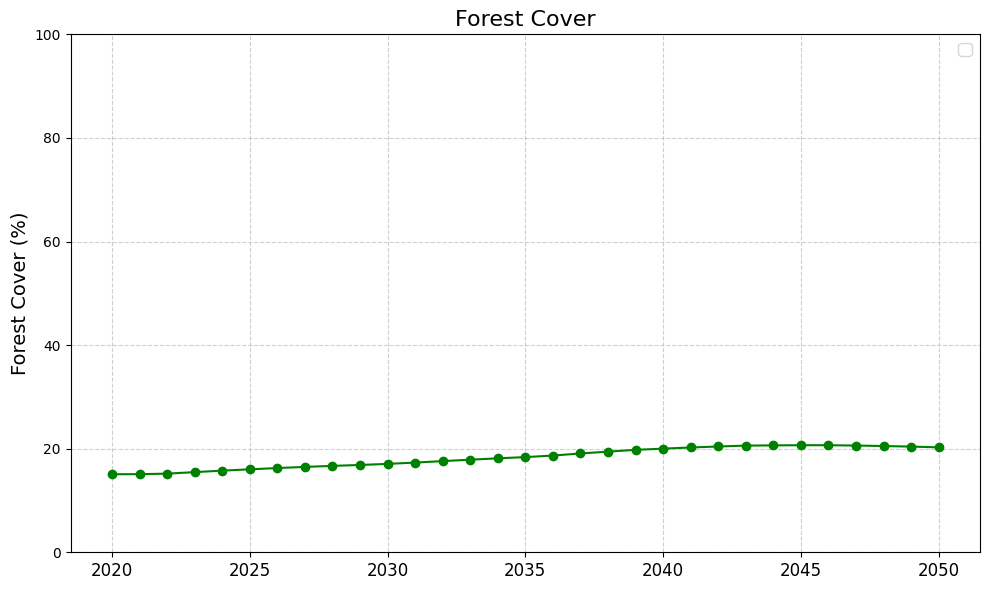

In [54]:
# Exit if the indicator is not of interest
if Forest_Cover == False:
    exit()

# Load the data
forest_cover_path = os.path.join(Final_results, 'Forest_cover.csv')
forest_cover_data = pd.read_csv(forest_cover_path)

# Plot the data
plt.figure(figsize=(10, 6))

# Create histogram
#plt.bar(forest_cover_data['YEAR'], forest_cover_data['VALUE'], color='lightgreen', alpha=0.7)

# Add a trend line
plt.plot(forest_cover_data['YEAR'], forest_cover_data['VALUE'], marker='o', color='green')

# Customize the plot
plt.title('Forest Cover', fontsize=16)
plt.xticks(ticks=forest_cover_data['YEAR'][::5], labels=forest_cover_data['YEAR'][::5], fontsize=12)
plt.ylabel('Forest Cover (%)', fontsize=14)
plt.ylim(0,100)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'ForestCover.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.2 Harvested area 

C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\2577727070.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\HarvestedArea.png


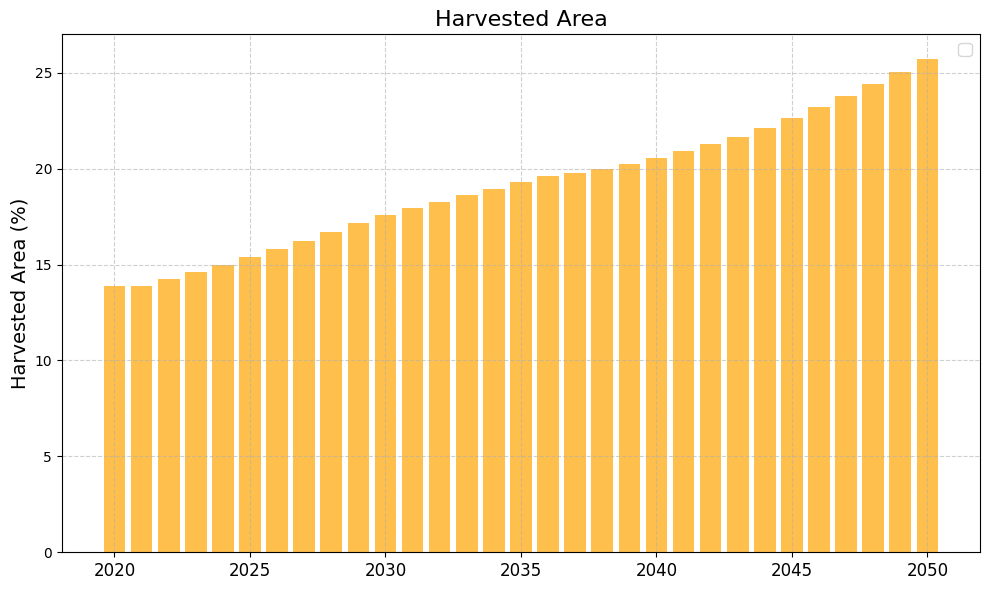

In [ ]:
# Exit if the indicator is not of interest
if Harvested_Area == False:
    exit()
# Load the data
Harvested_path = os.path.join(Final_results, 'Harvested_area.csv')
Harvested_data = pd.read_csv(Harvested_path)

# Plot the data
plt.figure(figsize=(10, 6))
# Create histogram
plt.bar(Harvested_data['YEAR'], Harvested_data['VALUE'], color='orange', alpha=0.7)


# Customize the plot
plt.title('Harvested Area', fontsize=16)
plt.xticks(ticks=Harvested_data['YEAR'][::5], labels=Harvested_data['YEAR'][::5], fontsize=12)
plt.ylabel('Harvested Area (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'HarvestedArea.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")


### 6.3 Area under irrigation

C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\2885639207.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\AreaUnderIrrigation.png


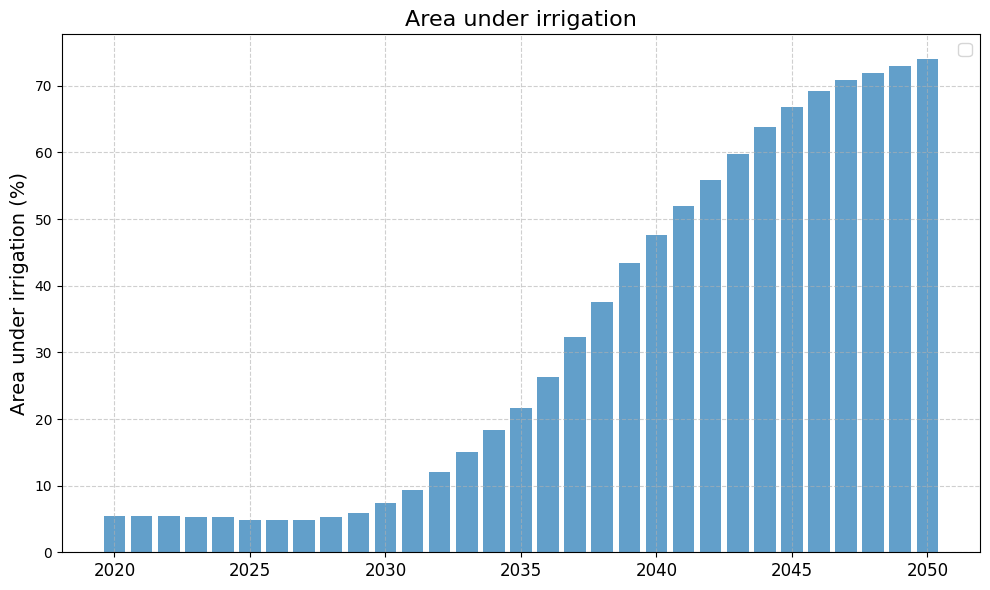

In [53]:
# Exit if the indicator is not of interest
if Irrigated_Area == False:
    exit()

# Load the data
path = os.path.join(Final_results, 'Irrigated_area.csv')
data = pd.read_csv(path)

# Plot the data
plt.figure(figsize=(10, 6))
# Create histogram
plt.bar(data['YEAR'], data['VALUE'], alpha=0.7)


# Customize the plot
plt.title('Area under irrigation', fontsize=16)
plt.xticks(ticks=data['YEAR'][::5], labels=data['YEAR'][::5], fontsize=12)
plt.ylabel('Area under irrigation (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'AreaUnderIrrigation.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.4 Crop yield

Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\Crop_Yield.png


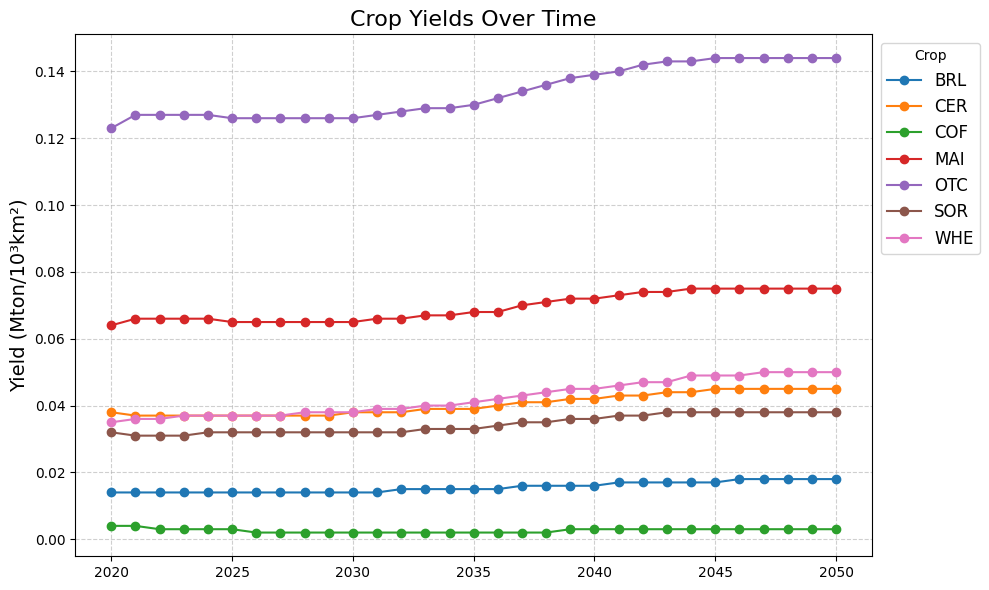

In [ ]:
# Exit if the indicator is not of interest
if Yield == False:
    exit()

# Load the data
path = os.path.join(Final_results, 'Crop_Yield.csv')
data = pd.read_csv(path)

# Convert the YEAR column to integers
data['YEAR'] = data['YEAR'].astype(int)

# Sort the data by YEAR for each crop
data = data.sort_values(by=['CROP', 'YEAR'])

# Plot each crop's data
plt.figure(figsize=(10, 6))
for crop in data['CROP'].unique():
    crop_data = data[data['CROP'] == crop]
    plt.plot(crop_data['YEAR'], crop_data['VALUE'], marker='o', linestyle='-', label=crop)

# Customize the plot
plt.title('Crop Yields Over Time', fontsize=16)
plt.ylabel(f'Yield ({Yield_Unit})', fontsize=14)
plt.legend(title='Crop', fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'Crop_Yield.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.5 Biodiversity

C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\1293501516.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\BHI.png


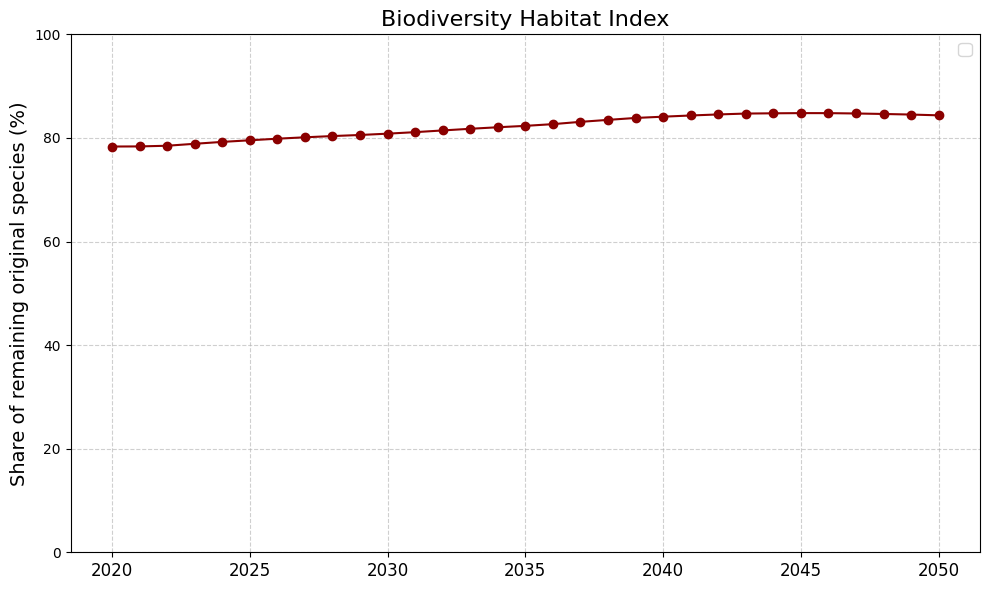

In [ ]:
# Exit if the indicator is not of interest
if BHI == False:
    exit()
    
# Load the data
path = os.path.join(Final_results, 'BHI.csv')
data = pd.read_csv(path)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot
plt.plot(data['YEAR'], data['VALUE'], marker='o', color='darkred')

# Customize the plot
plt.title('Biodiversity Habitat Index', fontsize=16)
plt.xticks(ticks=data['YEAR'][::5], labels=data['YEAR'][::5], fontsize=12)
plt.ylabel('Share of remaining original species (%)', fontsize=14)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'BHI.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.6 Net emissions 

C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3274123533.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\NetEmissions.png


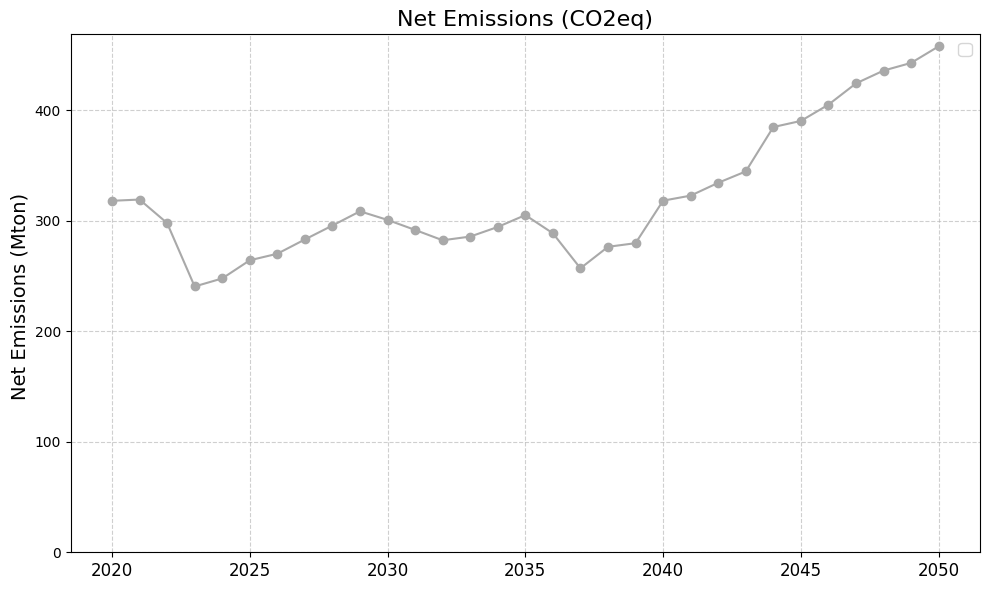

In [ ]:
# Exit if the indicator is not of interest
if NE == False:
    exit()

# Load the data
path = os.path.join(Final_results, 'Net_emissions.csv')
data = pd.read_csv(path)

# Plot the data
plt.figure(figsize=(10, 6))
# Create histogram
#plt.bar(data['YEAR'], data['VALUE'], color='gray', alpha=0.7)

# Add a trend line
plt.plot(data['YEAR'], data['VALUE'], marker='o', color='darkgray')

# Customize the plot
plt.title(f'Net Emissions ({Emission_Type[0]})', fontsize=16)
plt.xticks(ticks=data['YEAR'][::5], labels=data['YEAR'][::5], fontsize=12)
plt.ylabel(f'Net Emissions ({Unit_of_measure}) ', fontsize=14)
plt.ylim(0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'NetEmissions.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.7 Relative water demand

C:\Users\camlg\AppData\Local\Temp\ipykernel_25964\3884069020.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\RelativeWaterDemand.png


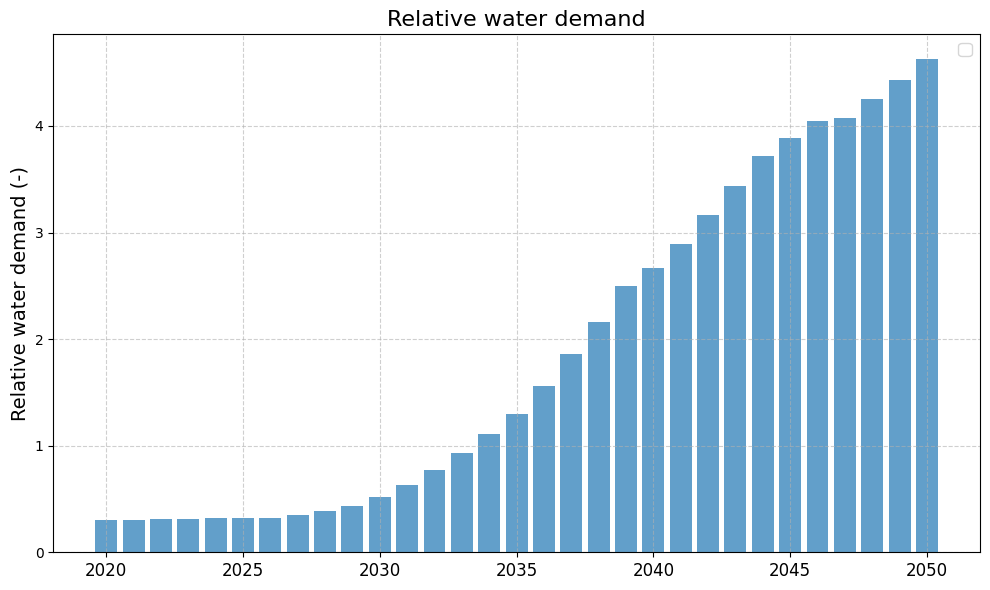

In [52]:
# Exit if the indicator is not of interest
if ws_aa == False:
    exit()

# Load the data
path = os.path.join(Final_results, 'Relative_annual_water_demand.csv')
data = pd.read_csv(path)

# Plot the data
plt.figure(figsize=(10, 6))
# Create histogram
plt.bar(data['YEAR'], data['VALUE'], alpha=0.7)

# Customize the plot
plt.title('Relative water demand', fontsize=16)
plt.xticks(ticks=data['YEAR'][::5], labels=data['YEAR'][::5], fontsize=12)
plt.ylabel('Relative water demand (-)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'RelativeWaterDemand.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.8 Average annual water stress

Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\AverageAnnualWaterStress.png


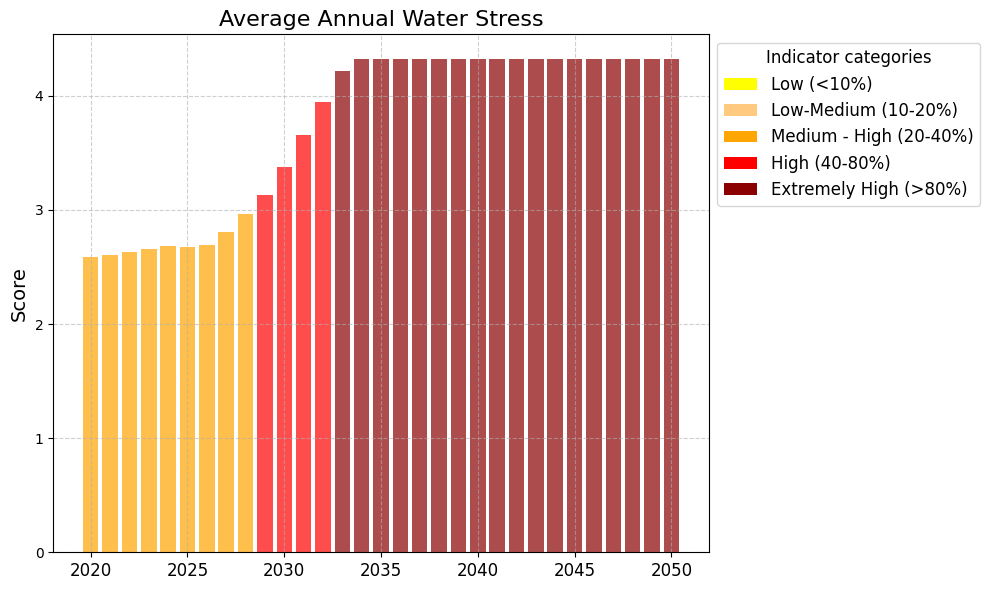

In [ ]:
# Exit if the indicator is not of interest
if ws_aa == False:
    exit()

# Load the data
path = os.path.join(Final_results, 'Annual_average_ws_score.csv')
data = pd.read_csv(path)

# Define colors based on the score range
colors = []
for value in data['VALUE']:
    if 0 <= value < 1:
        colors.append('yellow')  
    elif 1 <= value < 2:
        colors.append("#ffca80")  
    elif 2 <= value < 3:
        colors.append('orange')
    elif 3 <= value < 4:
        colors.append('red')
    elif 4 <= value <= 5:
        colors.append('darkred')

# Plot the data
plt.figure(figsize=(10, 6))
# Create histogram with conditional colors
plt.bar(data['YEAR'], data['VALUE'], color=colors, alpha=0.7)


# Customize the plot
plt.title('Average Annual Water Stress', fontsize=16)
plt.xticks(ticks=data['YEAR'][::5], labels=data['YEAR'][::5], fontsize=12)
plt.ylabel('Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
legend_elements = [
    Patch(facecolor= 'yellow' , label='Low (<10%)'),
    Patch(facecolor= "#ffca80", label='Low-Medium (10-20%)'),
    Patch(facecolor='orange', label='Medium - High (20-40%)'),
    Patch(facecolor='red', label='High (40-80%)'),
    Patch(facecolor='darkred', label='Extremely High (>80%)')
]
plt.legend(handles=legend_elements, title='Indicator categories', fontsize=12, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'AverageAnnualWaterStress.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.9 Crop dependency ratio on imports

Plot saved to c:\Users\camlg\OneDrive - KTH\Skrivbordet\01.KTH-PhD\04.IAM compact\01.Paper\Indicators4CLEWs\Plots\Crop_IDR.png


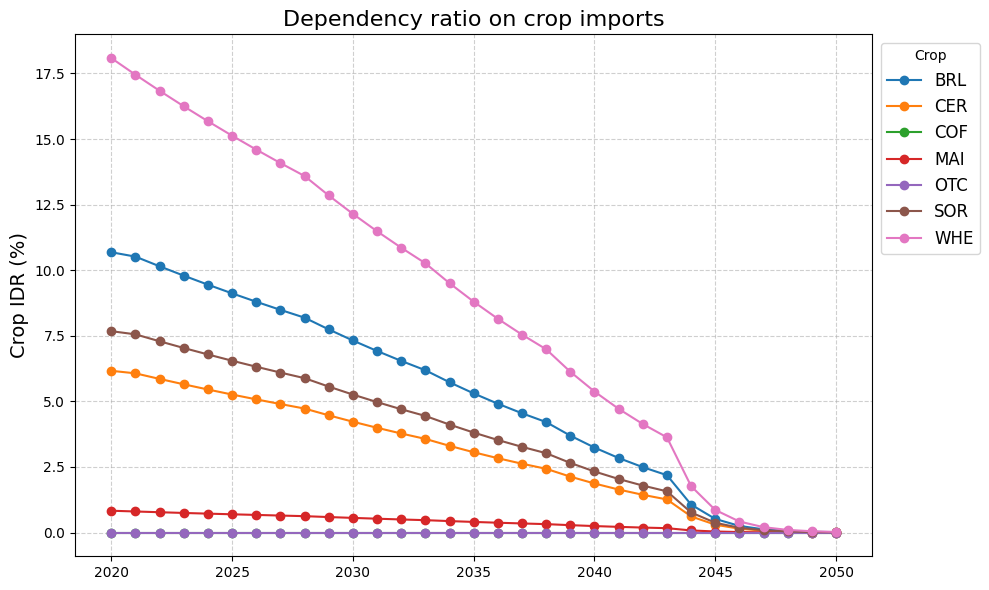

In [ ]:
# Exit if the indicator is not of interest
if Crop_IDR == False:
    exit()

# Load the data
path = os.path.join(Final_results, 'Crop_IDR.csv')
data = pd.read_csv(path)

# Convert the YEAR column to integers
data['YEAR'] = data['YEAR'].astype(int)

# Sort the data by YEAR for each crop
data = data.sort_values(by=['CROP', 'YEAR'])

# Plot each crop's data
plt.figure(figsize=(10, 6))
for crop in data['CROP'].unique():
    crop_data = data[data['CROP'] == crop]
    plt.plot(crop_data['YEAR'], crop_data['VALUE'], marker='o', linestyle='-', label=crop)

# Customize the plot
plt.title('Dependency ratio on crop imports', fontsize=16)
plt.ylabel('Crop IDR (%)', fontsize=14)
plt.legend(title='Crop', fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'Crop_IDR.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

### 6.10 Harvested area under high managment 

In [9]:
# Exit if there are no management levels
if Managment_level == False:
    exit()

# Load the data
path = os.path.join(Final_results, 'HM_area.csv')
data = pd.read_csv(path)

# Plot the data
plt.figure(figsize=(10, 6))
# Create histogram
plt.bar(data['YEAR'], data['VALUE'], alpha=0.7)


# Customize the plot
plt.title('Harvested area under high managment', fontsize=16)
plt.xticks(ticks=data['YEAR'][::5], labels=data['YEAR'][::5], fontsize=12)
plt.ylabel('Harvested area under high managment (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(Plots, 'High_Managment_Area.png')
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to {plot_path}")

NameError: name 'Managment_level' is not defined

## Summary

In [13]:
Indicators = [Forest_Cover, Harvested_Area, Irrigated_Area, Yield, BHI, NE, ws_aa, Crop_IDR]

indicator_names = [
    "Forest_Cover", "Harvested_Area", "Irrigated_Area", "Yield",
    "BHI", "NE", "ws_aa", "Crop_IDR"
]

def analyze_indicators(indicators, names):
    true_indicators = []
    false_indicators = []
    for value, name in zip(indicators, names):
        if value:
            true_indicators.append(name)
        else:
            false_indicators.append(name)
    
    print(f"The analysis returned the following indicators: {true_indicators}")
    
    if false_indicators:
        print(f"If you want to display {false_indicators} indicators, change the settings in the configuration cell.")

analyze_indicators(Indicators, indicator_names)

The analysis returned the following indicators: ['Harvested_Area', 'Irrigated_Area', 'Yield', 'BHI', 'NE', 'ws_aa', 'Crop_IDR']
If you want to display ['Forest_Cover'] indicators, change the settings in the configuration cell.
